# Classifying Heart Disease in Patients using Multivariate 
#### Research question: Which physiological risk factors are most suitable for accurately classifying heart disease among patients?

## Introduction

- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question 

This dataset includes the many factors considered to identify the presence of heart disease in a patient. The attributes we will consider include age, sex, and rest BP (resting blood pressure in mm Hg on admission to the hospital). We will use these attributes to train the program to be able to predict the presence of heart disease (yes heart disease is present, no for heart disease is not present) in new patients. 

## Preliminary exploratory data analysis

- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


In [67]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
set.seed(100)

In [68]:
## Wrangling and cleaning the data
heart_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_cols <- c("age", "sex", "chest_pain_type", "rest_bp", "cholesterol", "fast_blood_sugar", "rest_ecg", "max_hr", "ex_angina", "st_depr", "slope_peak", "major_vessel_num", "thal", "pres_val")
heart_data <- read_csv(heart_data_url, col_names = heart_cols) |>
    mutate(sex = as.factor(sex),
          chest_pain_type = as.factor(chest_pain_type),
          fast_blood_sugar = as.factor(fast_blood_sugar),
          rest_ecg = as.factor(rest_ecg),
          ex_angina = as.factor(ex_angina),
          slope_peak = as.factor(slope_peak),
          major_vessel_num = as.factor(major_vessel_num),
          thal = as.factor(as.integer(thal)),
          pres_val = as.factor(pres_val),
          presence = as.factor(ifelse(pres_val == 0, "no", "yes")))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): major_vessel_num, thal
dbl (12): age, sex, chest_pain_type, rest_bp, cholesterol, fast_blood_sugar,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in is.factor(x):
“NAs introduced by coercion”


age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr,ex_angina,st_depr,slope_peak,major_vessel_num,thal,pres_val,presence
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,1,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7,3,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3,1,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3,0,no


Table 1: Wrangled and cleaned heart data

In [69]:
## Splitting the data into training/testing set
heart_split <- heart_data |>
    select(age, rest_bp, cholesterol, max_hr, st_depr, presence) |>
    initial_split(prop = 0.75, strata = presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [70]:
## Summarizing the training data (number of observations in each class)
heart_train_summary <- heart_train |>
    group_by(presence) |>
    summarize(count = n())
heart_train_summary

presence,count
<fct>,<int>
no,123
yes,104


Table 2: Summary of number of observations that do and do not contain the presence of heart disease

In [71]:
## Calculating means of the predictor variables
heart_train_predictors_mean <- heart_train |>
    select(-presence) |>
    colMeans()
as.data.frame.list(heart_train_predictors_mean)

age,rest_bp,cholesterol,max_hr,st_depr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.43612,131.6256,248.7753,149.4758,1.028634


Table 3: Means of each predictor

predictor,value
<chr>,<dbl>
age,63
rest_bp,145
cholesterol,233
⋮,⋮
cholesterol,131.0
max_hr,115.0
st_depr,1.2


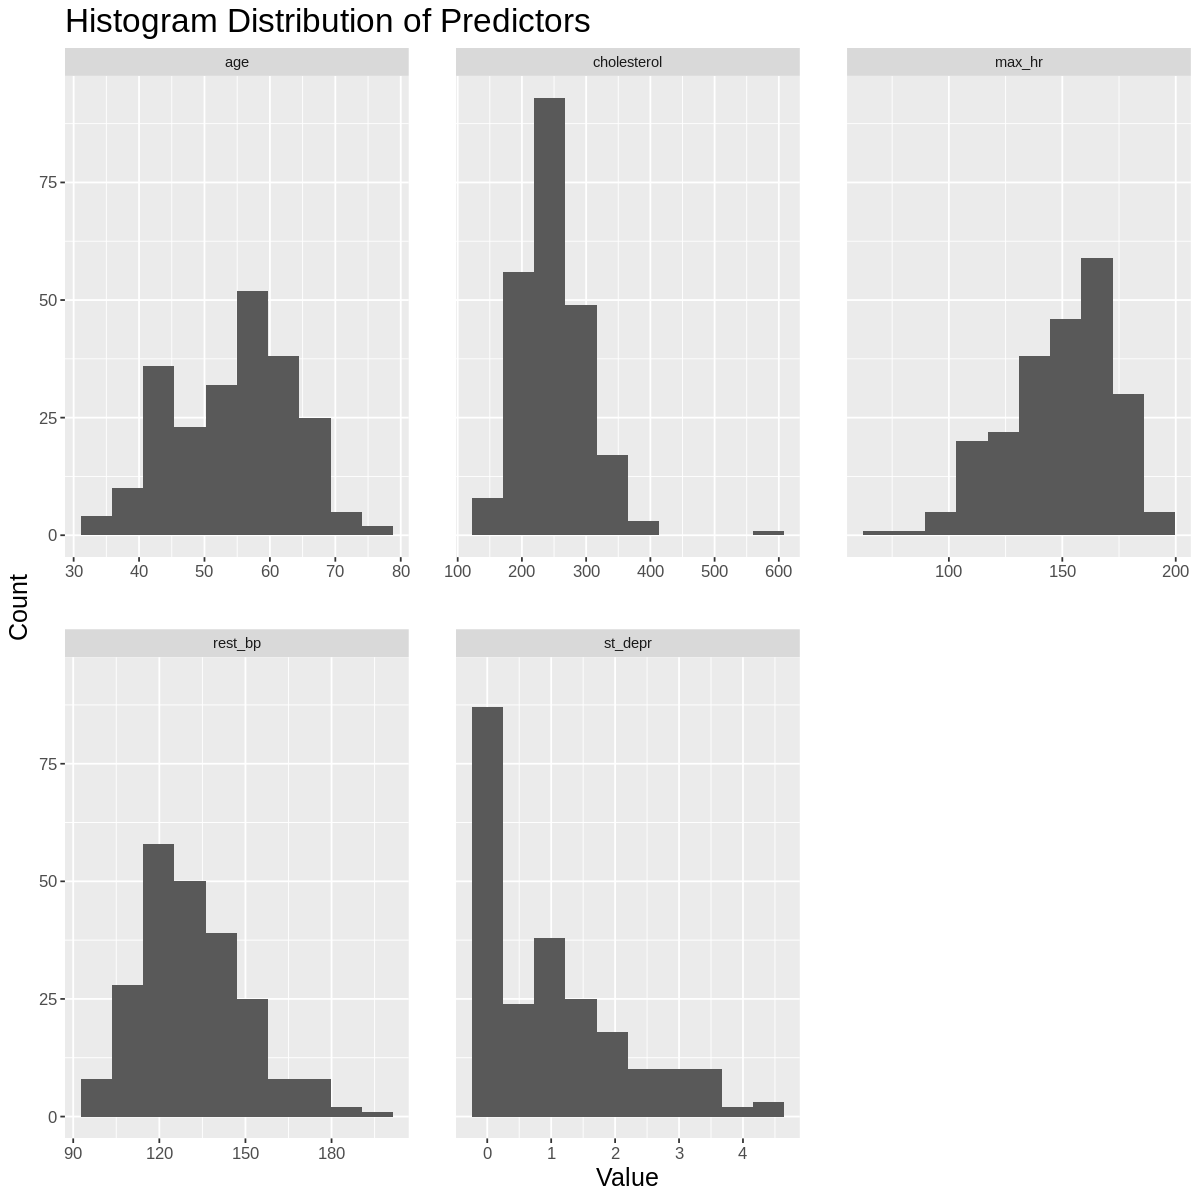

In [72]:
## Visualizing the training data (histogram distributions of each predictor column)
heart_train_long <- heart_train |>
    select(-presence) |>
    pivot_longer(cols = everything(), names_to = "predictor", values_to = "value")

heart_train_long

heart_train_predictor_plot <- heart_train_long |>
    ggplot(aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~predictor, scales = 'free_x') +
    ggtitle("Histogram Distribution of Predictors") +
    labs(y = "Count", x = "Value") +
    theme(panel.spacing = unit(1, "cm")) +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 10)) + 
    theme(plot.title = element_text(size = 20))

heart_train_predictor_plot

In [73]:
## Scaling the data (starting here everything is actually beyond the proposal)
heart_data_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled <- heart_data_recipe |>
    prep() |>
    bake(heart_data)
heart_data_scaled

age,rest_bp,cholesterol,max_hr,st_depr,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9471596,0.7562740,-0.2644628,0.01716893,1.0855423,no
1.3897030,1.6085589,0.7591593,-1.81889638,0.3965257,yes
1.3897030,-0.6642009,-0.3417173,-0.90086373,1.3439235,yes
⋮,⋮,⋮,⋮,⋮,⋮
0.2833446,-0.09601098,-2.2344526,-1.512885,0.1381444,yes
0.2833446,-0.09601098,-0.2065219,1.066349,-0.8953805,yes
-1.8187363,0.35854099,-1.3846531,1.022633,-0.8953805,no


Table 4: Scaled heart data

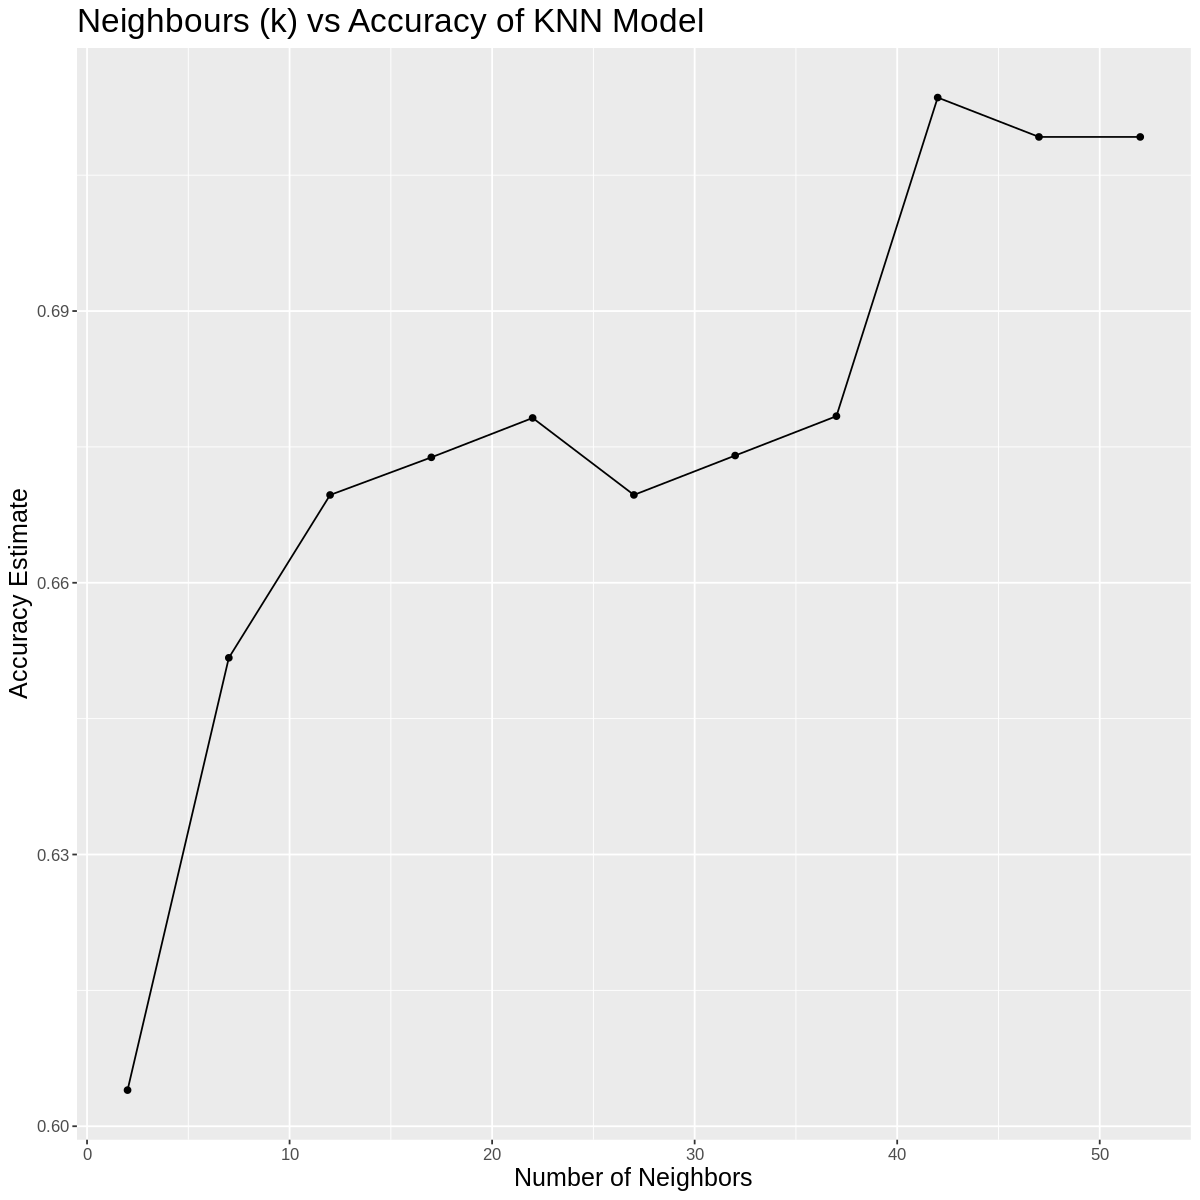

In [74]:
## Finding the optimal k
set.seed(1)
knn_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_train)

heart_train <- knn_recipe |>
    prep() |>
    bake(heart_train)

knn_vfold <- vfold_cv(heart_train, v = 5, strata = presence)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k <- tibble(neighbors = seq(2, 52, 5))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Neighbours (k) vs Accuracy of KNN Model") +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 10)) + 
    theme(plot.title = element_text(size = 20))

cross_val_plot

In [75]:
## Testing the model
knn_spec <- nearest_neighbor(weight = "rectangular", neighbor = 42) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

knn_predictions <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)

knn_metrics <- knn_predictions |>
    metrics(truth = presence, estimate = .pred_class)

knn_conf_mat <- knn_predictions |>
    conf_mat(truth = presence, estimate = .pred_class)

knn_conf_mat

          Truth
Prediction no yes
       no  35  15
       yes  6  20

Table 5: Confusion matrix

Percent Accuracy of Model:

In [76]:
## Calculating percent accuracy of model
percent_accuracy <- (35 + 20) / (35 + 20 + 6 + 15)
percent_accuracy

[1] 0.7236842

## Methods

For our data analysis, we will use tidymodel’s K-nearest neighbours to classify a new patient as either having heart disease or not. The data set has designated numbers 0 to 4 to represent the various classes of the heart disease diagnosis, with 0 indicating no heart disease and 4 indicating heart disease. A value of 0 suggests the absence of significant heart disease while a value of 1 suggests the presence of heart disease.

We plan on following the main data analysis workflow steps when designing a K-nearest neighbours model to ensure efficiency and clarity. After tidying the data, filtering out the unneeded columns, and scaling and centering the data, we will split the data into a training set and a testing set and use the training set for cross validation. After analyzing the accuracies of various K values using a graph, we will choose the most reliable K value for our K-nearest neighbours model specification, recipe, and workflow.

The raw data contains thirteen columns that have the potential to act as predictors for the diagnosis of heart disease. In our data analysis, we will only use five of these: resting blood pressure in mm Hg (trestbps), serum cholesterol in mg/dl (chol), the number of cigarettes smoked per day (cigs), family history of coronary artery disease (famhist), and whether or not the patient’s fasting blood sugar is greater than 120 mg/dl (fbs).

We will visualize the accuracy of each K value by creating a line plot depicting each K value and their respective accuracy. The plot of accuracy vs. number of neighbours will be used to choose the best K value. Additionally, we will visualize the final results by graphing all of the testing data on a scatter plot with each point coloured based on their predicted classification using our best classification model (one colour corresponds to each number from 0 to 4).

## Expected outcomes and significance

   As our project is based on a heart disease data set, we are planning to find whether there are any differences in the occurrence of heart disease in different age groups and genders and also about the relationship between certain risk factors such as cholesterol, blood sugar and the development of the heart disease. And also, we are expecting to find whether there are any common symptoms or indicators of heart disease in the dataset.

 There are some possible impacts on such kind of findings regarding heart disease issues, they are healthcare professionals can better understand the risk factors for heart disease in different populations by identifying significant variations in the incidence of the disease.  And some other important impacts can be early diagnosis, generally in the early diagnosis doctors recommend patients to take scanning’s and some tests to check whether the patient is healthy or is he/she are developing a heart disease.
        Early identification of the disease also plays a role because it will be simple to identify basing on the common symptoms.  And also the possible solution for this is also personalized treatment, which means to figure out which is making the heart affected by risk factors and also sorting a way to figure it out by good treatment.

 Depending upon the impacts and our expected findings some of the future questions regarding this could be:
   1. Are there any methods to enhance heart disease diagnostic and screening procedures to ensure earlier recognition and treatment?
   3. How can healthcare professionals better inform the people about typical heart disease symptoms or warning signs to increase early detection?
   4. For certain age groups or genders at greater risk of heart disease, are there particular interventions or treatment modalities that are more successful?
  
   